In [162]:
import glob, os
from IPython.display import clear_output
import time as time
from tabulate import tabulate
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
import librosa
from librosa import display
import numpy as np
import statistics

import datetime
from collections import deque
import progressbar

import scipy.stats as st

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
from sklearn.metrics import confusion_matrix

# Data Collection & Pre-Processing

In [163]:
# We need to construct our data set; unfortunately, we don't simply have a "loadGTZanDataSet()" function in SK-learn...
# So we need to 
## Download our data set & extract it (one-time effort)
## Run an audio feature extraction
## Create the create the ground truth (label assignment, target, ...) 

# path to our audio folder
# For the first run, download the images from http://kronos.ifs.tuwien.ac.at/GTZANmp3_22khz.zip, and unzip them to your folder
songsPath='C:\\Users\\mailb\\Desktop\\MLE_Music_Data\\'

# Find all songs in that folder; there are like 1.000 different ways to do this in Python, we chose this one :-)
os.chdir(songsPath)
fileNames = glob.glob("*/*.mp3")
numberOfFiles=len(fileNames)
targetLabels=[]

print("Found " + str(numberOfFiles) + " files\n")

# The first step - create the ground truth (label assignment, target, ...) 
# For that, iterate over the files, and obtain the class label for each file
# Basically, the class name is in the full path name, so we simply use that
for fileName in fileNames:
    pathSepIndex = fileName.index("\\")
    targetLabels.append(fileName[:pathSepIndex])

# sk-learn can only handle labels in numeric format - we have them as strings though...
# Thus we use the LabelEncoder, which does a mapping to Integer numbers
le = preprocessing.LabelEncoder()
le.fit(targetLabels) # this basically finds all unique class names, and assigns them to the numbers
print("Found the following classes: " + str(list(le.classes_)))

# now we transform our labels to integers
target = le.transform(targetLabels); 
print("Transformed labels (first elements: " + str(target[0:150]))

# If we want to find again the label for an integer value, we can do something like this:
# print(list(le.inverse_transform([0, 18, 1]))

print("... done label encoding")

Found 1000 files

Found the following classes: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Transformed labels (first elements: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
... done label encoding


In [164]:
heart_failure = pd.read_csv(r'G:\My Drive\FH_Technikum\MSC\Semester_2_SS2022\MLE\heart_failure_clinical_records_dataset.csv')
heart_failure.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [191]:
covertype = pd.read_csv(r'G:\My Drive\FH_Technikum\MSC\Semester_2_SS2022\MLE\covtype.data', header=None).sample(n=200000, random_state=547998)
covertype.describe()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,2959.207110,155.728340,14.113695,269.953635,46.622240,2349.950475,212.143625,223.346055,142.545385,1979.321895,...,0.092055,0.077535,0.002940,0.003075,0.000200,0.000490,0.027025,0.023895,0.015125,2.051595
std,280.194532,111.871525,7.496689,212.178192,58.352252,1559.966989,26.769663,19.768909,38.261783,1324.572119,...,0.289104,0.267439,0.054142,0.055367,0.014141,0.022131,0.162157,0.152722,0.122050,1.396121
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2808.000000,58.000000,9.000000,108.000000,7.000000,1103.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2995.000000,127.000000,13.000000,218.000000,30.000000,1994.000000,218.000000,226.000000,143.000000,1707.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3164.000000,260.000000,18.000000,390.000000,69.000000,3332.000000,231.000000,237.000000,168.000000,2549.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3857.000000,360.000000,65.000000,1397.000000,597.000000,7116.000000,254.000000,254.000000,254.000000,7142.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


The dataset for coverage (woodland coverage) had to be reduced due to the fact that the SVC classifier scales extremely badly and a dataset of 500.000 took far too long to process. In the attempts, I did not receive a result after hours of runtime.

To retain a certain comparability, all classifiers are trained with the reduced dataset. The data is sampled randomly.

# Visualization Of Features

Showing demo feature extraction on song C:\Users\mailb\Desktop\MLE_Music_Data\blues\blues.00001.mp3


c:\Users\mailb\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
C:\Users\mailb\AppData\Local\Temp\ipykernel_12936\2359787827.py:10: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0284729  -0.04879761
 -0.04025269] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_env = librosa.onset.onset_strength(y, sr=sr)


The song has [107.66601562] beats per minute


c:\Users\mailb\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)


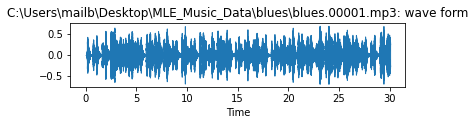

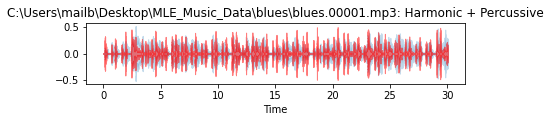

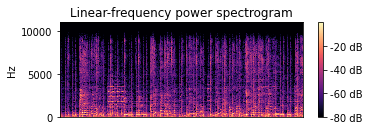

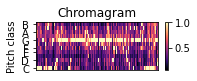

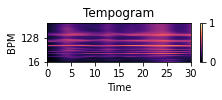

In [166]:
# Before we extract the features, let's plot some information on a demo song, to illustrate what we are doing

demoSongName = fileNames[1]
demoSongPath = songsPath + demoSongName
print("Showing demo feature extraction on song " + demoSongPath)

y, sr = librosa.load(demoSongPath)

# compute the tempo
onset_env = librosa.onset.onset_strength(y, sr=sr)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
print("The song has " + str(tempo) + " beats per minute")

# plot the wave form
plt.figure()
plt.subplot(3, 1, 1)
display.waveshow(y, sr=sr)
plt.title(demoSongPath + ': wave form')

y_harm, y_perc = librosa.effects.hpss(y)
plt.figure()
plt.subplot(3, 1, 3)
display.waveshow(y_harm, sr=sr, alpha=0.25)
display.waveshow(y_perc, sr=sr, color='r', alpha=0.5)
plt.title(demoSongPath + ': Harmonic + Percussive')
plt.tight_layout()

# Plot the power spectrum
plt.figure(figsize=(12, 8))
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.subplot(4, 2, 1)
display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

# Plot Chroma
plt.figure()
C = librosa.feature.chroma_cqt(y=y, sr=sr)
plt.subplot(4, 2, 5)
display.specshow(C, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')

# Plot tempogram
plt.figure()
plt.subplot(4, 2, 8)
Tgram = librosa.feature.tempogram(y=y, sr=sr)
display.specshow(Tgram, x_axis='time', y_axis='tempo')
plt.colorbar()
plt.title('Tempogram')
plt.tight_layout()


plt.show()

In [167]:
classified_filenames = {'Filename': fileNames, 'Class': target}

files_dataframe = DataFrame(classified_filenames)

# Feature Extraction

In [168]:
# This is a helper function that computes the differences between adjacent array values
def differences(seq):
    iterable = iter(seq)
    prev = next(iterable)
    for element in iterable:
        yield element - prev
        prev = element

# This is a helper function that computes various statistical moments over a series of values, including mean, median, var, min, max, skewness and kurtosis (a total of 7 values)
def generate_statistics(numericList):
    return [np.mean(numericList),
        np.median(numericList),
        np.var(numericList),
        np.float64(st.skew(numericList)),
        np.float64(st.kurtosis(numericList)),
        np.min(numericList),
        np.max(numericList)]

print("Extracting features using librosa" + " (" + str(datetime.datetime.now()) + ")")

# compute some features based on BPMs, MFCCs, Chroma
data_bpm=[]
data_bpm_statistics=[]
data_mfcc=[]
data_chroma=[]

# # This takes a bit, so let's show it with a progress bar
with progressbar.ProgressBar(max_value=len(files_dataframe), poll_interval=20) as bar:
    for indexSample, fileName in enumerate(files_dataframe['Filename']):
        # Load the audio as a waveform `y`, store the sampling rate as `sr`
        y, sr = librosa.load(fileName)

        # run the default beat tracker
        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
        # from this, we simply use the tempo as BPM feature
        data_bpm.append([tempo])

        # Then we compute a few statistics on the beat timings
        beat_times = librosa.frames_to_time(beat_frames, sr=sr)
        # from the timings, compute the time differences between the beats
        beat_intervals = np.array(deque(differences(beat_times)))

        # And from this, take some statistics
        # There might be a few files where the beat timings are not determined properly; we ignore them, resp. give them 0 values
        if len(beat_intervals) < 1:
            print("Errors with beat interval in file " + fileName + ", index " + str(indexSample) + ", using 0 values instead")
            data_bpm_statistics.append([tempo, 0, 0, 0, 0, 0, 0, 0])
        else:
            bpm_statisticsVector=[]
            bpm_statisticsVector.append(tempo) # we also include the raw value of tempo
            for stat in generate_statistics(beat_intervals):  # in case the timings are ok, we actually compute the statistics
                bpm_statisticsVector.append(stat) # and append it to the vector, which finally has 1 + 7 features
            data_bpm_statistics.append(bpm_statisticsVector)

        # Next feature are MFCCs; we take 12 coefficients; for each coefficient, we have around 40 values per second
        mfccs=librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12)
        mfccVector=[]
        for mfccCoefficient in mfccs: # we transform this time series by taking again statistics over the values
            mfccVector.append(generate_statistics(mfccCoefficient))

        # Finally, this vector should have 12 * 7 features
        data_mfcc.append(np.array(mfccVector).flatten())


        # Last feature set - chroma (which is roughly similar to actual notes)
        chroma=librosa.feature.chroma_stft(y=y, sr=sr);
        chromaVector=[]
        for chr in chroma: # similar to before, we get a number of time-series
            chromaVector.append(generate_statistics(chr)) # and we resolve that by taking statistics over the time series
        # Finally, this vector should be be 12 * 7 features
        data_chroma.append(np.array(chromaVector).flatten())

        clear_output(wait=True)
        bar.update(indexSample)

print(".... done" + " (" + str(datetime.datetime.now()) + ")")

 99% (999 of 1000) |#################### | Elapsed Time: 0:40:16 ETA:   0:00:02
100% (1000 of 1000) |####################| Elapsed Time: 0:40:16 Time:  0:40:16


.... done (2022-05-29 14:28:22.841156)


In [192]:
# These are our feature sets; we will use each of them individually to train classifiers
trainingSets = [
    {'data': data_bpm, 'class': files_dataframe.Class, 'title': 'Beats per minute' },
    {'data': data_bpm_statistics, 'class': files_dataframe.Class, 'title': 'Beats per minute statistics' },
    {'data': data_chroma, 'class': files_dataframe.Class, 'title': 'Chroma' },
    {'data': data_mfcc, 'class': files_dataframe.Class, 'title': 'Mel Frequency Cepstral Coefficients' },
    {'data': heart_failure.loc[:,:'smoking'], 'class': heart_failure.loc[:,'DEATH_EVENT':], 'title': 'Heart Failure'},
    {'data': covertype.loc[:,:53], 'class': covertype.loc[:,54:], 'title': 'Forest Cover Type'}
]

# Classification

## K-NN

In [193]:
classifier_results_table_headers = ['Classifier', 'Parameters', 'Dataset', 'Training time (seconds)', 'Test time (seconds)', 'Accuracy', 'Weighted F1', 'Predicted values', 'Test values']
measurements = DataFrame(columns=classifier_results_table_headers)

In [194]:
classifier_name = 'K-NN'

for trainingSet in trainingSets:
    print("Processing training set: " + str(trainingSet['title']))
    
    X_train, X_test, y_train, y_test = train_test_split(trainingSet['data'], trainingSet['class'], test_size=0.33, random_state=547998)
            
    training_times = []
    test_times = []
    accuracy_measures = []
    weithged_f1_measures = []
    neighbors_params = [3, 5, 10]

    for n_neighbors in neighbors_params:
        classifier = neighbors.KNeighborsClassifier(n_neighbors = n_neighbors, algorithm='kd_tree')
         
        start_training = time.time()
        modle = classifier.fit(X=X_train, y=y_train.values.ravel())
        training_time = time.time() - start_training

        start_testing = time.time()
        y_pred = modle.predict(X=X_test)
        test_time = time.time() - start_testing
        
        accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
        f1_measure = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')

        measurements.loc[len(measurements)] = [ classifier_name, 'neighbors: ' + str(n_neighbors), trainingSet['title'], training_time, test_time, accuracy, f1_measure, y_pred, y_test]


Processing training set: Beats per minute
Processing training set: Beats per minute statistics
Processing training set: Chroma
Processing training set: Mel Frequency Cepstral Coefficients
Processing training set: Heart Failure
Processing training set: Forest Cover Type


## Perceptron

In [195]:
classifier_name = 'Perceptron'

for trainingSet in trainingSets:
    print("Processing training set: " + str(trainingSet['title']))
    
    X_train, X_test, y_train, y_test = train_test_split(trainingSet['data'], trainingSet['class'], test_size=0.33, random_state=547998)
            
    training_times = []
    test_times = []
    accuracy_measures = []
    weithged_f1_measures = []
    alphas = np.logspace(-1, 1, 5)
    penalties = ['l2', 'l1']

    for alpha in alphas:
        for penalty in penalties:
            classifier = linear_model.Perceptron(alpha=alpha, penalty=penalty, random_state=547998)

            start_training = time.time()
            modle = classifier.fit(X=X_train, y=y_train.values.ravel())
            training_time = time.time() - start_training

            start_testing = time.time()
            y_pred = modle.predict(X=X_test)
            test_time = time.time() - start_testing
            
            accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
            f1_measure = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')

            measurements.loc[len(measurements)] = [ classifier_name, 'alpha: ' + str(alpha) + ' penalty: ' + str(penalty), trainingSet['title'], training_time, test_time, accuracy, f1_measure, y_pred, y_test]

Processing training set: Beats per minute
Processing training set: Beats per minute statistics
Processing training set: Chroma
Processing training set: Mel Frequency Cepstral Coefficients
Processing training set: Heart Failure
Processing training set: Forest Cover Type


## Decision Tree

In [196]:
classifier_name = 'Decision Tree'

for trainingSet in trainingSets:
    print("Processing training set: " + str(trainingSet['title']))
    
    X_train, X_test, y_train, y_test = train_test_split(trainingSet['data'], trainingSet['class'], test_size=0.33, random_state=547998)
            
    training_times = []
    test_times = []
    accuracy_measures = []
    weithged_f1_measures = []
    min_samples_splits = [2, 50, 100, 1000]
    min_samples_leafs = [1, 50, 100, 1000]

    for min_samples_split in min_samples_splits:
        for min_samples_leaf in min_samples_leafs:
            classifier = tree.DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=min_samples_split, random_state=547998)

            start_training = time.time()
            modle = classifier.fit(X=X_train, y=y_train.values.ravel())
            training_time = time.time() - start_training

            start_testing = time.time()
            y_pred = modle.predict(X=X_test)
            test_time = time.time() - start_testing
            
            accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
            f1_measure = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')

            measurements.loc[len(measurements)] = [ classifier_name, 'min. samples/split: ' + str(min_samples_split) + ' min. samples/leaf: ' + str(min_samples_leaf), trainingSet['title'], training_time, test_time, accuracy, f1_measure, y_pred, y_test]

Processing training set: Beats per minute
Processing training set: Beats per minute statistics
Processing training set: Chroma
Processing training set: Mel Frequency Cepstral Coefficients
Processing training set: Heart Failure
Processing training set: Forest Cover Type


## Random Forest

In [197]:
classifier_name = 'Random Forest'

for trainingSet in trainingSets:
    print("Processing training set: " + str(trainingSet['title']))
    
    X_train, X_test, y_train, y_test = train_test_split(trainingSet['data'], trainingSet['class'], test_size=0.33, random_state=547998)
            
    training_times = []
    test_times = []
    accuracy_measures = []
    weithged_f1_measures = []
    n_estimators = [20, 100] # = Number of trees
    max_features = ['sqrt', 'log2']

    for n_estimators_value in n_estimators:
        for max_features_value in max_features:
            classifier = ensemble.RandomForestClassifier(n_estimators=n_estimators_value, max_features=max_features_value, random_state=547998)

            start_training = time.time()
            modle = classifier.fit(X=X_train, y=y_train.values.ravel())
            training_time = time.time() - start_training

            start_testing = time.time()
            y_pred = modle.predict(X=X_test)
            test_time = time.time() - start_testing
            
            accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
            f1_measure = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')

            measurements.loc[len(measurements)] = [ classifier_name, 'n estimators: ' + str(n_estimators_value) + ' max. feaatures: ' + str(max_features_value), trainingSet['title'], training_time, test_time, accuracy, f1_measure, y_pred, y_test]

Processing training set: Beats per minute
Processing training set: Beats per minute statistics
Processing training set: Chroma
Processing training set: Mel Frequency Cepstral Coefficients
Processing training set: Heart Failure
Processing training set: Forest Cover Type


## SVM (SVC-Classifier)

In [198]:
classifier_name = 'SVC'

for trainingSet in trainingSets:
    print("Processing training set: " + str(trainingSet['title']))

    X_train, X_test, y_train, y_test = train_test_split(trainingSet['data'], trainingSet['class'], test_size=0.33, random_state=547998)

    training_times = []
    test_times = []
    accuracy_measures = []
    weithged_f1_measures = []

    classifier = svm.SVC(random_state=547998)

    start_training = time.time()
    modle = classifier.fit(X=X_train, y=y_train.values.ravel())
    training_time = time.time() - start_training

    start_testing = time.time()
    y_pred = modle.predict(X=X_test)
    test_time = time.time() - start_testing
    
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    f1_measure = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')

    measurements.loc[len(measurements)] = [ classifier_name, 'SVC default', trainingSet['title'], training_time, test_time, accuracy, f1_measure, y_pred, y_test]

-----------------------------------------------------
Processing training set: Beats per minute
-----------------------------------------------------
-----------------------------------------------------
Processing training set: Beats per minute statistics
-----------------------------------------------------
-----------------------------------------------------
Processing training set: Chroma
-----------------------------------------------------
-----------------------------------------------------
Processing training set: Mel Frequency Cepstral Coefficients
-----------------------------------------------------
-----------------------------------------------------
Processing training set: Heart Failure
-----------------------------------------------------
-----------------------------------------------------
Processing training set: Forest Cover Type
-----------------------------------------------------


## Results

In [202]:
measurements_table_data = measurements.iloc[:, :7]
decimals = 5
measurements_table_data['Training time (seconds)'] = measurements_table_data['Training time (seconds)'].round(decimals)
measurements_table_data['Test time (seconds)'] = measurements_table_data['Test time (seconds)'].round(decimals)
measurements_table_data['Accuracy'] = measurements_table_data['Accuracy'].round(decimals)
measurements_table_data['Weighted F1'] = measurements_table_data['Weighted F1'].round(decimals)
print(tabulate(measurements_table_data, headers='keys', tablefmt='orgtbl'))

|     | Classifier    | Parameters                                       | Dataset                             |   Training time (seconds) |   Test time (seconds) |   Accuracy |   Weighted F1 |
|-----+---------------+--------------------------------------------------+-------------------------------------+---------------------------+-----------------------+------------+---------------|
|   0 | K-NN          | neighbors: 3                                     | Beats per minute                    |                   0.002   |               0.00601 |    0.12121 |       0.08792 |
|   1 | K-NN          | neighbors: 5                                     | Beats per minute                    |                   0.00099 |               0.005   |    0.15152 |       0.13115 |
|   2 | K-NN          | neighbors: 10                                    | Beats per minute                    |                   0.001   |               0.005   |    0.14545 |       0.13897 |
|   3 | K-NN          | neighb

The best result regarding accuracy was produced with the Cover Type dataset and the K-NN classifier using 3 Neighbors. The training took 2,682 seconds and the testing took 4,456 seconds. These are very reasonable times, considering that SVC took 1449,45 seconds when processing the Cover Type dataset. It is clear that SVC scales badly when analyzing the processing times.

In [200]:
measurements_table_data.to_csv('C:/Users/mailb/Desktop/results.csv', sep=';', index=False, decimal=',')

In [248]:
labelEncoder = preprocessing.LabelEncoder()
classes = np.array(['-', 'Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz'])
labelEncoder.fit(classes)

LabelEncoder()

In [241]:
# Selecting index 15 (cover type with k-nn classifier and 3 neighbors) for the confusion matrix
test_classes = labelEncoder.inverse_transform(measurements.iloc[15]['Test values'][54].to_numpy())
predicted_classes = labelEncoder.inverse_transform(measurements.iloc[15]['Predicted values'])

In [249]:
conf_matrix = pd.DataFrame(
    confusion_matrix(test_classes, predicted_classes, labels=classes, normalize = 'true', ),
    index = classes,
    columns = classes
)

conf_matrix = round(conf_matrix, 5)

print('Best performing algorithm: ' + measurements.iloc[15]['Classifier'])
print('Accuracy: ' + str(measurements.iloc[15]['Accuracy']))
print('Weighted F1: ' + str(measurements.iloc[15]['Weighted F1']))
conf_matrix.iloc[1:,1:]

Best performing algorithm: K-NN
Accuracy: 0.9345606060606061
Weighted F1: 0.9343877268504108


,Spruce/Fir,Lodgepole Pine,Ponderosa Pine,Cottonwood/Willow,Aspen,Douglas-fir,Krummholz
Spruce/Fir,0.93755,0.00042,0.00000,0.00253,0.05949,0.00000,0.00000
Lodgepole Pine,0.00000,0.78739,0.00282,0.17121,0.02446,0.01411,0.00000
Ponderosa Pine,0.00000,0.00303,0.86125,0.05701,0.00404,0.07265,0.00202
Cottonwood/Willow,0.00012,0.00419,0.00214,0.94772,0.04222,0.00357,0.00003
Aspen,0.00425,0.00112,0.00004,0.06168,0.93291,0.00000,0.00000
Douglas-fir,0.00000,0.00148,0.02964,0.03162,0.00099,0.93207,0.00420
Krummholz,0.00000,0.00000,0.09464,0.00315,0.00000,0.21767,0.68454


In [247]:
conf_matrix.iloc[1:,1:].to_csv('C:/Users/mailb/Desktop/confusion_matrix.csv', sep=';', index=True, decimal=',')